## Aufgabe 3
### Erstellen eines Linearen Regressionsmodells

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

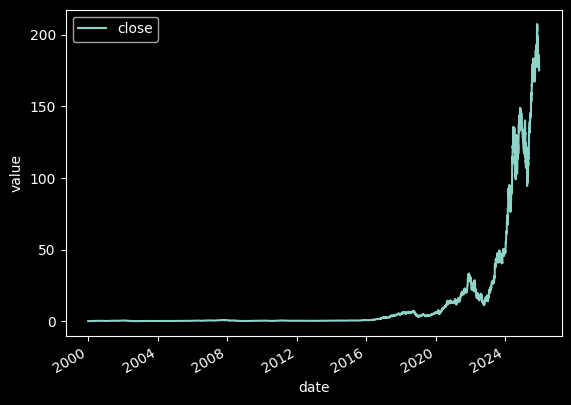

In [2]:
PROCESSED = Path("..", "data") / "processed" # TODO Delete

df = pd.read_csv(PROCESSED / "df_nasdaq_daily.csv")
df = df.loc[df["ticker"] == "NVDA"].reset_index(drop=True)
df = df.drop("ticker", axis=1)
df["date"] = pd.to_datetime(df["date"])

ax = df.plot.line("date", "close", ylabel="value")

plt.show()

In [7]:
TEST_SIZE = 0.2

def lin_regression(X: np.ndarray, y: np.ndarray) -> tuple[LinearRegression, float]:
    """Trains a linear Regression Model\nReturns the model and the Mean Squared Error"""

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_predicted = model.predict(X_test)

    mse = mean_squared_error(y_test, y_predicted)

    return model, mse

In [8]:
entries = df.shape[0]
features = 14   # 2 * 7 (days)

X = np.empty((entries - features, features))
y = np.empty((entries - features))

for row in df.iterrows():
    if row[0] < features:
        continue

    y[row[0] - features] = df.iloc[row[0]]["close"]

    # Open and Close value in the past seven days
    for i in range(7):
        X[row[0] - features, 2 * i] = df.iloc[row[0] - 1 - i]["open"]
        X[row[0] - features, 2 * i + 1] = df.iloc[row[0] - 1 - i]["close"]

_, mse = lin_regression(X, y)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.9820790349430415


Aus dem Mean Squared Error ergibt sich, dass das Modell keine groben Fehler macht.
Jedoch ist dieser Wert noch zu ungenau, da die Aktien unterschiedlich Wert sind.
Wenn sich das Modell bei einer Aktie, die nur ein paar Cent wert ist, um den Faktor 3 verschätzt,
macht das kaum einen Unterschied, da der Mean Squared Error die Differenz (also auch nur einen Cent Betrag) hernimmt.
Um diesem Problem entgegenzuwirken, werden die Aktien Werte nun normalisiert.


In [9]:
entries = df.shape[0]
features = 14   # 2 * 7 (days)

X = np.empty((entries - features, features))
y = np.empty((entries - features))

for row in df.iterrows():
    if row[0] < features:
        continue

    normal_val = df.iloc[row[0] - 1]["close"]   # Close value of day before; used for normalize process

    y[row[0] - features] = df.iloc[row[0]]["close"] / normal_val

    # Open and Close value in the past seven days
    for i in range(7):
        X[row[0] - features, 2 * i] = df.iloc[row[0] - 1 - i]["open"] / normal_val
        X[row[0] - features, 2 * i + 1] = df.iloc[row[0] - 1 - i]["close"] / normal_val

_, mse = lin_regression(X, y)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0013534992369060189


Auf den ersten Blick könnte man meinen, dass unser Modell aufgrund des geringen Mean Squared Error ziehmlich genau sein muss.
Jedoch ist die Durchschnittliche Abweichung $$\sqrt{mse} \approx 0.035$$ was immerhin eine durschnittliche Abweichung von 3.5% ist

Das Modell kann nun ungefähr den nächsten Close Wert vorhersagen. Dieser liegt jedoch in den meisten Fällen im Bereich der letzten Close Werte. Es gibt kaum starke Veränderungen.
Dies liegt zum Einen an dem linearen Regressionsmodell, das keine komplexen Zusammenhänge "versteht" und zum anderen an den mangelnden Daten zur Wirtschaftslage.
Denn der Hype und Neuerungen im Unternehmen beeinflussen den Aktienkurs maßgeblich.
Außerdem: Wenn man so einfach einen Aktienkurs genau vorhersagen könnte, wären alle Studenten im DAT-Kurs (und noch viele andere) Millionäre :)